# Light Curve Fitting with ExoCTK
ExoCTK performs light curve fitting with the `exoctk.lightcurve_fitting` tool. This notebook will show you how to do it. 

First, some imports and a toy light curve to work with:

In [1]:
# Imports
import numpy as np
import astropy.units as q
from exoctk.lightcurve_fitting.lightcurve import LightCurve
from exoctk.lightcurve_fitting.parameters import Parameters
from exoctk.lightcurve_fitting.models import PolynomialModel, TransitModel
%matplotlib inline

In [2]:
# Toy data
time = np.linspace(0, 1, 100)
raw_flux = [0.95 if 35<i<60 else 1 for i in range(100)]
unc = np.random.uniform(low=1E-4, high=0.01, size=100)
flux = np.random.normal(raw_flux, scale=unc)
flux[55:60] *= np.linspace(1, 1.05, 5)
flux[36:41] *= np.linspace(1.05, 1., 5)

## Create a light curve
Creating a light curve instance is simple. Just pass `exoctk.lightcurve_fitting.lightcurve.LightCurve()` a `time` and `flux` array. You can also pass it the associated uncertainty with the `unc` argument.

The `units` argument is just the units of the given time axis, in this case 'day'.

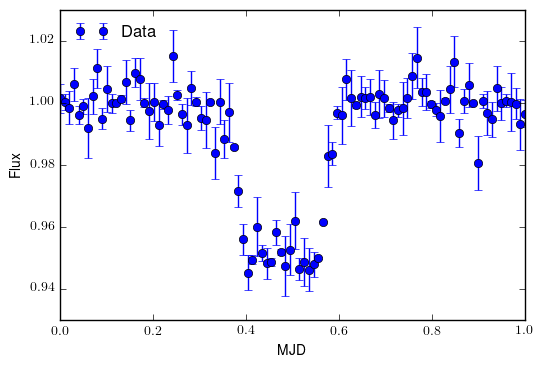

In [3]:
# Instantiate a lightcurve
lc = LightCurve(time, flux, unc, name='Data')
lc.plot()

## Create some models to fit to the light curve
Now that we have our light curve data loaded, let's create some models to fit to it.

First we'll create a simple linear model by passing some polynomial coefficients to the `PolynomialModel` class.

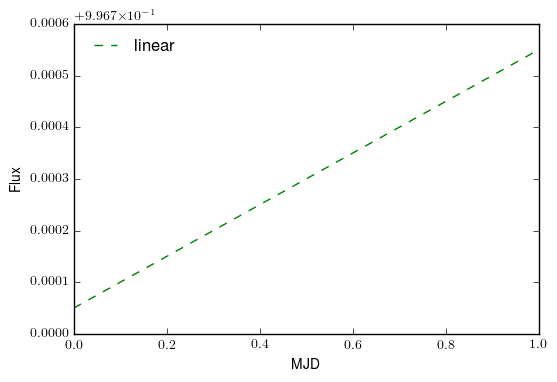

In [4]:
# Create a PolynomialModel instance with coeffs [c0, c1]. Also give it a name and format for fun.
lin_model = PolynomialModel(c1=0.0005, c0=0.997, name='linear', fmt='g--')

# Plot it
lin_model.plot(time)

Let's also create a transit model with the `ExoCTK.lightcurve_fitting.models.TransitModel` class. We can pass the arguments `rp`, `per`, `t0`, etc. directly to the `TransitModel` instance, or we can create a `ExoCTK.lightcurve_fitting.parameters.Parameters` instance first like so:

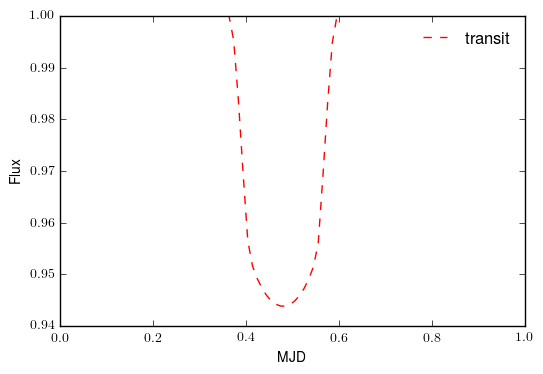

In [5]:
# Set the intial parameters
params = Parameters()
params.rp = 0.22, 'free', 0.0, 0.4  # rprs
params.per = 10.721490, 'fixed'
params.t0 = 0.48, 'free', 0, 1
params.inc = 89.7, 'free', 80., 90.
params.a = 18.2, 'free', 15., 20.    # aprs
params.ecc = 0., 'fixed'
params.w = 90., 'fixed'             # omega
params.limb_dark = '4-parameter', 'independent'
params.transittype = 'primary', 'independent'
params.u1 = 0.1, 'free', 0., 1.
params.u2 = 0.1, 'free', 0., 1.
params.u3 = 0.1, 'free', 0., 1.
params.u4 = 0.1, 'free', 0., 1.

# Make the transit model
t_model = TransitModel(parameters=params, name='transit', fmt='r--')

# Plot it
t_model.plot(time)

An arbitrary number of models can then be multiplied to produce a `ExoCTK.lightcurve_fitting.models.CompositeModel` to fit to the data.

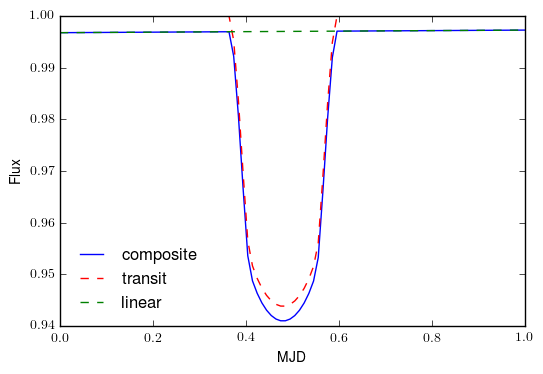

In [6]:
# Make a new model by multiplying some model components (which don't necessarily overlap)
comp_model = t_model*lin_model
comp_model.name = 'composite'

# Plot it
comp_model.plot(time, components=True)

## Fit the model to the light curve data
To fit a model to the data, we need to supply the `LightCurve.fit()` method with a `Model` instance and then specify our choice of fitting routine. Here we'll use the `lmfit` fitter with our composite model create above.

[[Model]]
    Model(eval)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 121
    # data points      = 100
    # variables        = 10
    chi-square         = 2360.54407
    reduced chi-square = 26.2282675
    Akaike info crit   = 336.147722
    Bayesian info crit = 362.199424
[[Variables]]
    rp:   0.28762222 (init = 0.22)
    per:  10.72149 (fixed)
    t0:   0.77970522 (init = 0.48)
    inc:  81.8991217 (init = 89.7)
    a:    18.1665144 (init = 18.2)
    ecc:  0 (fixed)
    w:    90 (fixed)
    u1:   0.99798367 (init = 0.1)
    u2:   0.99798367 (init = 0.1)
    u3:   0.99798367 (init = 0.1)
    u4:   0.99798367 (init = 0.1)
    c0:   3.58492896 (init = 0.997)
    c1:   2.58842896 (init = 0.0005)



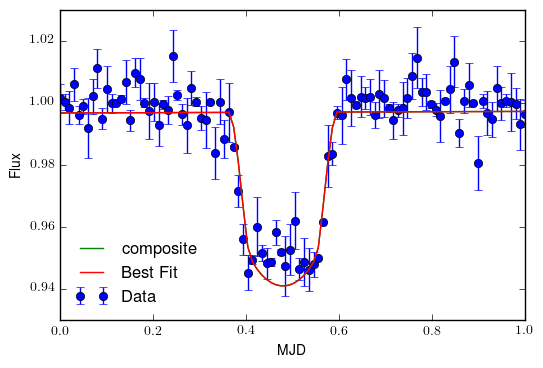

In [11]:
# Create a new model instance from the best fit parameters
best_fit_model = lc.fit(comp_model, fitter='lmfit')

# Plot it
lc.plot()
comp_model.plot(time)
best_fit_model.plot(time)

Now let's make some fake data from the composite model, rather than just random points.

[[Model]]
    Model(eval)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 121
    # data points      = 100
    # variables        = 10
    chi-square         = 77.2362183
    reduced chi-square = 0.85818020
    Akaike info crit   = -5.83016901
    Bayesian info crit = 20.2215328
[[Variables]]
    rp:   0.28762222 (init = 0.22)
    per:  10.72149 (fixed)
    t0:   0.77970522 (init = 0.48)
    inc:  81.8991217 (init = 89.7)
    a:    18.1665144 (init = 18.2)
    ecc:  0 (fixed)
    w:    90 (fixed)
    u1:   0.99798367 (init = 0.1)
    u2:   0.99798367 (init = 0.1)
    u3:   0.99798367 (init = 0.1)
    u4:   0.99798367 (init = 0.1)
    c0:   3.58492896 (init = 0.997)
    c1:   2.58842896 (init = 0.0005)



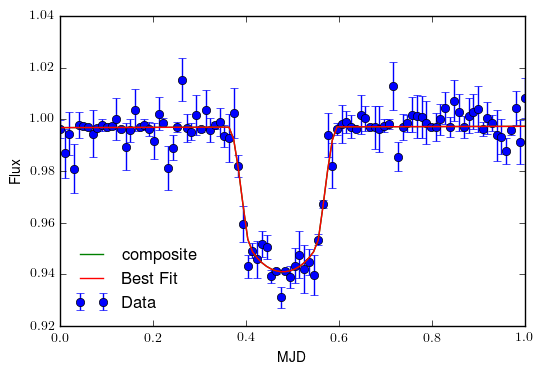

In [24]:
# Create a new model instance from the best fit parameters
raw_flux = comp_model.eval()
unc = np.random.uniform(low=1E-4, high=0.01, size=100)
flux = np.random.normal(raw_flux, scale=unc)
lc_sim = LightCurve(time, flux, unc, name='Data')

# Fit the lightcurve
best_fit_model_sim = lc_sim.fit(comp_model, fitter='lmfit')

# Plot it
lc_sim.plot()
comp_model.plot(time)
best_fit_model_sim.plot(time)